### Packages

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Load Cleaned Data Set

In [2]:
# Local Linked
# train_data = pd.read_csv("..\\Data\\train_data_EDA_processed.csv", index_col=0)

# Web Linked
train_data_EDA_processed_GITLINK = "https://raw.githubusercontent.com/ehsung/Capstone-Project-2---Identify-Genetic-Disorder-is-Children/master/Data/train_data_EDA_processed.csv"
train_data = pd.read_csv(train_data_EDA_processed_GITLINK, index_col=0)

In [3]:
train_data.T

0                1      \
Patient_Age                                           2.0              4.0   
Mother_Gene                                           Yes              Yes   
Father_Gene                                            No              Yes   
Maternal_Gene                                         Yes               No   
Paternal_Gene                                          No               No   
Blood_Cell                                       4.760603         4.910669   
Mother_Age                                            NaN              NaN   
Father_Age                                            NaN             23.0   
Status                                              Alive         Deceased   
Respiratory_Rate                           Normal (30-60)        Tachypnea   
Heart_Rate                                         Normal           Normal   
Follow_Up                                            High             High   
Gender                                                NaN              NaN   
Birth_Asphyxia                                        NaN               No   
Autopsy_Birth_Defect                                  NaN               No   
Birth_Place                                     Institute              NaN   
Folic_Acid_Details                                     No              Yes   
Maternal_Illness                                      NaN              Yes   
Radiation_Exposure                                     No              NaN   
Substance_Abuse                                        No              NaN   
Assisted_Conception                                    No               No   
History_Pregnancies                                   Yes              Yes   
Previous_Abortions                                    NaN              NaN   
Birth_Defects                                         NaN         Multiple   
White_Blood_Cell                                 9.857562          5.52256   
Blood_Test                                            NaN           normal   
Symptom_1                                             1.0              1.0   
Symptom_2                                             1.0              NaN   
Symptom_3                                             1.0              1.0   
Symptom_4                                             1.0              1.0   
Symptom_5                                             1.0              0.0   
Disorder_Subclass     Leber's hereditary optic neuropathy  Cystic fibrosis   

                               2               3            4      \
Patient_Age                      6.0            12.0         11.0   
Mother_Gene                      Yes             Yes          Yes   
Father_Gene                       No              No           No   
Maternal_Gene                     No             Yes          NaN   
Paternal_Gene                     No              No          Yes   
Blood_Cell                  4.893297         4.70528     4.720703   
Mother_Age                      41.0            21.0         32.0   
Father_Age                      22.0             NaN          NaN   
Status                         Alive        Deceased        Alive   
Respiratory_Rate      Normal (30-60)       Tachypnea    Tachypnea   
Heart_Rate               Tachycardia          Normal  Tachycardia   
Follow_Up                        Low            High          Low   
Gender                           NaN            Male         Male   
Birth_Asphyxia                   NaN             NaN          NaN   
Autopsy_Birth_Defect             NaN              No          NaN   
Birth_Place                      NaN       Institute    Institute   
Folic_Acid_Details               Yes              No           No   
Maternal_Illness                  No             Yes          Yes   
Radiation_Exposure               Yes             NaN          NaN   
Substance_Abuse                  NaN             NaN          NaN   
Assisted_Conception         

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19915 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient_Age           18672 non-null  float64
 1   Mother_Gene           19915 non-null  object 
 2   Father_Gene           19652 non-null  object 
 3   Maternal_Gene         17510 non-null  object 
 4   Paternal_Gene         19915 non-null  object 
 5   Blood_Cell            19915 non-null  float64
 6   Mother_Age            14719 non-null  float64
 7   Father_Age            14796 non-null  float64
 8   Status                19915 non-null  object 
 9   Respiratory_Rate      18058 non-null  object 
 10  Heart_Rate            18127 non-null  object 
 11  Follow_Up             18070 non-null  object 
 12  Gender                12008 non-null  object 
 13  Birth_Asphyxia        9060 non-null   object 
 14  Autopsy_Birth_Defect  9013 non-null   object 
 15  Birth_Place        

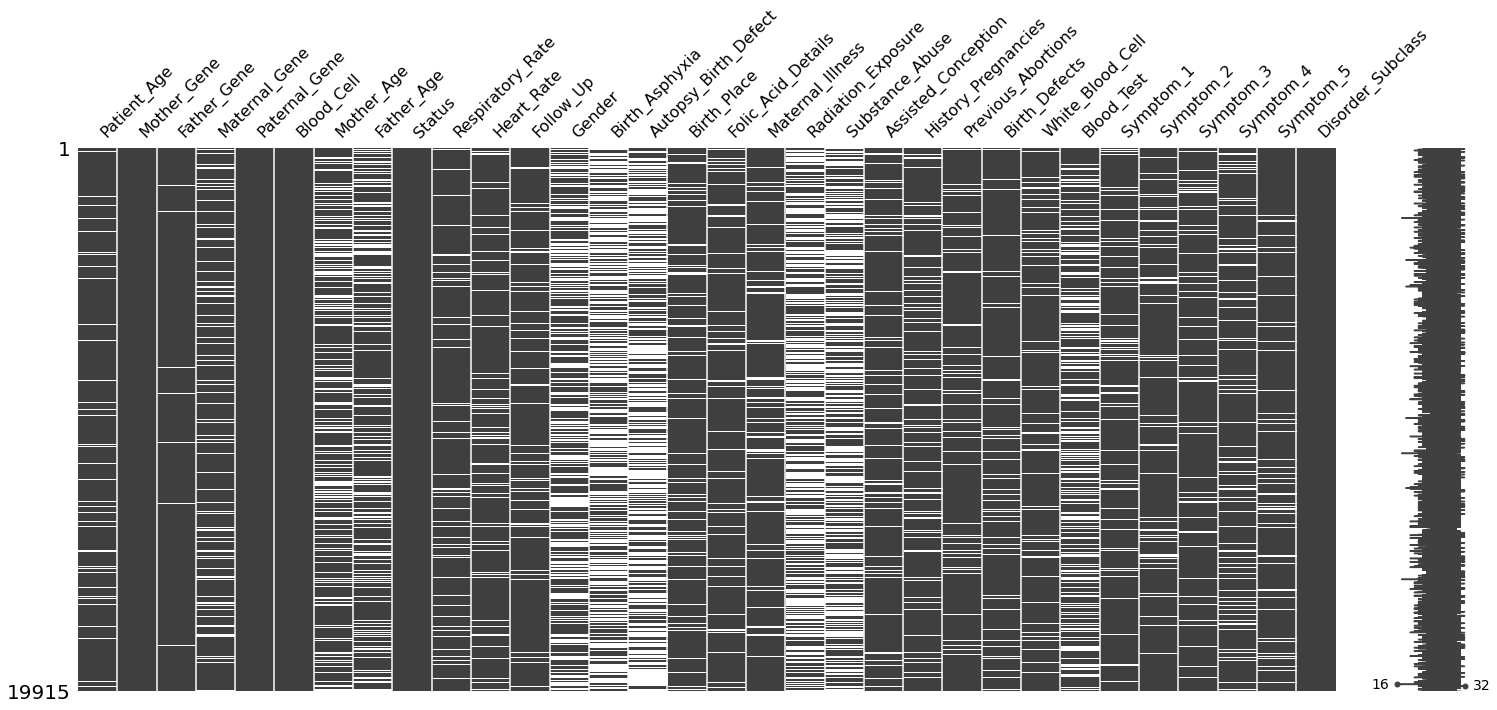

In [5]:
msno.matrix(train_data)
plt.show()

Leigh syndrome                         5160
Mitochondrial myopathy                 4405
Cystic fibrosis                        3448
Tay-Sachs                              2833
Diabetes                               1817
Hemochromatosis                        1355
Leber's hereditary optic neuropathy     648
Alzheimer's                             152
Cancer                                   97
Name: Disorder_Subclass, dtype: int64


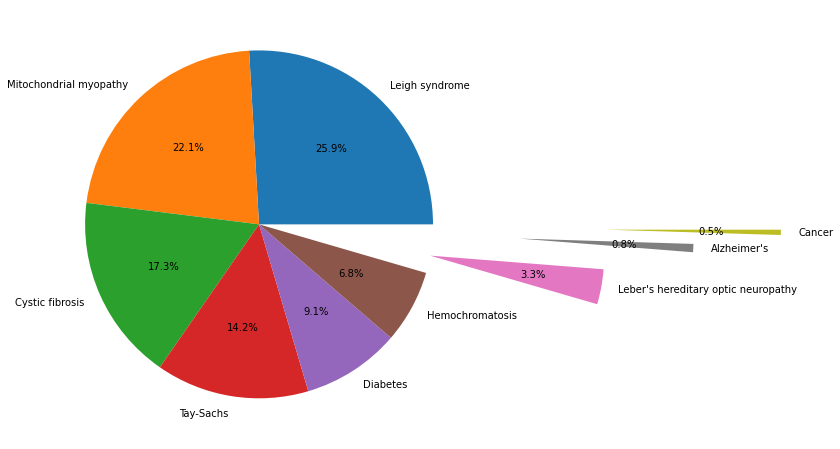

In [6]:
# Disorder Subclass Distribution
ds_counts = train_data.Disorder_Subclass.value_counts()
print(ds_counts)

plt.figure(figsize=(8,8))

mylab = ds_counts.index
explode = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1.5, 2)

plt.pie(ds_counts, labels=mylab, explode=explode, autopct='%1.1f%%')
plt.show()

### Road-Map Preprocessing 

Given the large amounts of missing data within certain columns and the misrepresentation effect that a mean or median imputation would have on the data when identifying disorder subclasses, I decided to go with constant imputation. Using constant imputation and creating missing values as its own catagorical group, I will have the model decide what information the missing values will be able to provide when classifying. Thus I will look into RandomForestClassifier, GradientBoostingClassifier and XGBoost, since they all use tree based modeling which are able to split on constant imputed missing values. These model algorithms also do not care and actually performs better without OneHotEncoding. This way, I will be able to keep track of my features.

### Preprocessing Pipeline

In [7]:
# Split the data into feature X and target y
X = train_data.drop(columns="Disorder_Subclass")
y = train_data.Disorder_Subclass

# Label encode target y
le = LabelEncoder()
encoded_y = le.fit_transform(y)

In [8]:
# Train Test Split by 20%
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.2, random_state=123)

In [9]:
# Grouped numerical columns
num_cols = train_data.select_dtypes('float64').columns

# Grouped categorical columns
cat_cols = train_data.select_dtypes('object').drop(columns="Disorder_Subclass").columns

# Preprocessing for numerical data
num_preprocessor = SimpleImputer(strategy='constant', fill_value=-99)

# Preprocessing for categorical data
cat_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="-99")),
                                   ('oe', OrdinalEncoder())])

# Combine num and cat preprocessor for data frame transformation
preprocessor = ColumnTransformer(
    transformers=[('num_transformer', num_preprocessor, num_cols),
                  ('cat_transformer', cat_preprocessor, cat_cols)])

In [10]:
# Preprocessor Test
feature_col_names = train_data.drop(columns="Disorder_Subclass").columns
preprocessed_df = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
preprocessed_df.columns = feature_col_names
preprocessed_df.head()

Patient_Age  Mother_Gene  Father_Gene  Maternal_Gene  Paternal_Gene  \
0          6.0     4.816182         23.0           32.0            4.0   
1         13.0     5.005324         28.0           44.0          -99.0   
2         10.0     4.712737         26.0          -99.0          -99.0   
3         13.0     5.095956        -99.0           36.0          -99.0   
4          8.0     4.847835         28.0           56.0            4.0   

   Blood_Cell  Mother_Age  Father_Age  Status  Respiratory_Rate  ...  \
0    5.321413         0.0         1.0     1.0               1.0  ...   
1    4.334729         1.0         1.0     1.0             -99.0  ...   
2    8.649998         1.0         0.0     0.0               0.0  ...   
3    7.548971         1.0         1.0     0.0               1.0  ...   
4    6.962187         1.0         1.0   -99.0               1.0  ...   

   History_Pregnancies  Previous_Abortions  Birth_Defects  White_Blood_Cell  \
0                  0.0                 1.0            0.0               2.0   
1                  1.0                 0.0            2.0               2.0   
2                  2.0                 2.0            2.0               1.0   
3                  0.0                 2.0            1.0               2.0   
4                  0.0                 2.0            1.0               2.0   

   Blood_Test  Symptom_1  Symptom_2  Symptom_3  Symptom_4  Symptom_5  
0         0.0        1.0        2.0        1.0        2.0        0.0  
1         0.0        0.0        2.0        1.0        1.0        0.0  
2         0.0        0.0        1.0        1.0        1.0        0.0  
3         0.0        0.0        2.0        1.0        0.0        1.0  
4         2.0        0.0        2.0        1.0        2.0        1.0  

[5 rows x 31 columns]

In [11]:
pd.DataFrame(preprocessor.fit_transform(X_train, y_train)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15932 entries, 0 to 15931
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       15932 non-null  float64
 1   1       15932 non-null  float64
 2   2       15932 non-null  float64
 3   3       15932 non-null  float64
 4   4       15932 non-null  float64
 5   5       15932 non-null  float64
 6   6       15932 non-null  float64
 7   7       15932 non-null  float64
 8   8       15932 non-null  float64
 9   9       15932 non-null  float64
 10  10      15932 non-null  float64
 11  11      15932 non-null  float64
 12  12      15932 non-null  float64
 13  13      15932 non-null  float64
 14  14      15932 non-null  float64
 15  15      15932 non-null  float64
 16  16      15932 non-null  float64
 17  17      15932 non-null  float64
 18  18      15932 non-null  float64
 19  19      15932 non-null  float64
 20  20      15932 non-null  float64
 21  21      15932 non-null  float64
 22

### Baseline Model Comparisons

In [12]:
# RandomForestClassifier
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('randomforest', RandomForestClassifier(random_state=123))])

pipe_rf.fit(X_train, y_train)

pred_tr = pipe_rf.predict(X_train)
pred_te = pipe_rf.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

100.0
37.98644238011549
Scores: [37.05679322 37.02541575 38.07281858 36.47206529 38.63779033]
Mean: 37.45297663471601
Standard Deviation: 0.007861226644058908


In [13]:
# GradientBoostingClassifier
pipe_gb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('gradientboosting', GradientBoostingClassifier(random_state=123))])

pipe_gb.fit(X_train, y_train)

pred_tr = pipe_gb.predict(X_train)
pred_te = pipe_gb.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_gb, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

48.70700477027366
40.321365804669846
Scores: [41.5123941  40.25729526 41.9648462  39.04582549 40.20715631]
Mean: 40.597503472105274
Standard Deviation: 0.01037542106070992


In [14]:
# XGBClassifier
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgboost', xgb.XGBClassifier(random_state=123, verbosity=0))])

pipe_xgb.fit(X_train, y_train)

pred_tr = pipe_xgb.predict(X_train)
pred_te = pipe_xgb.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

95.93899071051972
36.75621390911373
Scores: [37.15092564 37.6215877  39.98744507 37.22536095 36.34651601]
Mean: 37.66636707386469
Standard Deviation: 0.012321997709810498


Evaluating on the cross validated mean scores for each model, the GradientBoostingClassifier had the highest score with 40.6, but looking at its training score, it performed poorly at 48.7. For both the RandomForestClassifier and XGBClassifier, both have really high train score, showing that there is overfitting that can be regularized. But the XGBoost performed slightly better than the RandomForest.
I will be following through with XGBoost since it can deal well with imbalanced classes in my data set, as well being robust in modeling large amounts of missing data.

### Defining XGB Baseline Model

In [73]:
# Default parameters set to multi-classification
params = {
    'objective':'multi:softmax',
    'seed':123,
    'verbosity':0,
    'use_label_encoder':False
}

In [16]:
# Model without class weights
pipe_initial_noweights = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('xgboost', xgb.XGBClassifier(**params))])

pipe_initial_noweights.fit(X_train, y_train)

pred_tr = pipe_initial_noweights.predict(X_train)
pred_te = pipe_initial_noweights.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

95.93899071051972
36.75621390911373


In [17]:
# Cross Validation Score
scores = cross_val_score(pipe_initial_noweights, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [37.15092564 37.6215877  39.98744507 37.22536095 36.34651601]
Mean: 37.66636707386469
Standard Deviation: 0.012321997709810498


In [198]:
# Cross Validation Score for F1_Macro Score Metric baseline
scores = cross_val_score(pipe_initial_noweights, X_train, y_train, cv=5, scoring="f1_macro")
print("F1_Macro Scores:", scores * 100)
print("F1_Macro Scores Mean:", scores.mean() * 100)
print("F1_Macro Scores Standard Deviation:", scores.std())

F1_Macro Scores: [26.79352454 28.43989433 30.55707381 27.95283496 27.74751157]
F1_Macro Scores Mean: 28.298167841673518
F1_Macro Scores Standard Deviation: 0.012497336661110041


In [18]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.44      0.14      0.21        29
           1       0.80      0.17      0.29        23
           2       0.41      0.51      0.45       647
           3       0.35      0.26      0.30       346
           4       0.38      0.26      0.31       266
           5       0.29      0.15      0.20       126
           6       0.40      0.42      0.41      1072
           7       0.34      0.37      0.35       901
           8       0.31      0.29      0.30       573

    accuracy                           0.37      3983
   macro avg       0.41      0.29      0.31      3983
weighted avg       0.37      0.37      0.36      3983



In [75]:
# Adding Class Weight due to heavy imbalance of dataset seen in the EDA
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [20]:
# Model with class weights
pipe_initial = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgboost', xgb.XGBClassifier(**params))])

pipe_initial.fit(X_train, y_train, xgboost__sample_weight=sample_weights)

pred_tr = pipe_initial.predict(X_train)
pred_te = pipe_initial.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

92.58096911875471
35.32513181019332


In [21]:
# Cross Validation Score
scores = cross_val_score(pipe_initial, X_train, y_train, cv=5, scoring="accuracy", fit_params={'xgboost__sample_weight':sample_weights})
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [36.52337622 35.55067462 37.00564972 35.65599498 35.02824859]
Mean: 35.952788822923324
Standard Deviation: 0.007125507848876233


In [22]:
# Cross Validation Score for F1_Macro Score Metric baseline
scores = cross_val_score(pipe_initial, X_train, y_train, cv=5, scoring="f1_macro", fit_params={'xgboost__sample_weight':sample_weights})
print("F1_Macro Scores:", scores * 100)
print("F1_Macro Scores Mean:", scores.mean() * 100)
print("F1_Macro Scores Standard Deviation:", scores.std())

F1_Macro Scores: [30.26678641 30.39427911 29.76856274 28.50813865 31.21638715]
F1_Macro Scores Mean: 30.030830810700586
F1_Macro Scores Standard Deviation: 0.00892265599345136


In [23]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.24      0.14      0.17        29
           1       0.18      0.09      0.12        23
           2       0.39      0.48      0.43       647
           3       0.30      0.30      0.30       346
           4       0.29      0.36      0.32       266
           5       0.23      0.19      0.21       126
           6       0.42      0.34      0.38      1072
           7       0.36      0.33      0.34       901
           8       0.30      0.35      0.32       573

    accuracy                           0.35      3983
   macro avg       0.30      0.29      0.29      3983
weighted avg       0.36      0.35      0.35      3983



In [24]:
for i, val in enumerate(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])):
    print(i, val)

0 Alzheimer's
1 Cancer
2 Cystic fibrosis
3 Diabetes
4 Hemochromatosis
5 Leber's hereditary optic neuropathy
6 Leigh syndrome
7 Mitochondrial myopathy
8 Tay-Sachs


The initial model without class weights performs slightly better then the model with class weights. But the slight decrease to account for class_weights will hopefully lead to better learning model with tuning parameters to appropriately classify the small classes. The default parameters for XGBoost looks to be overfitting given then high 93-96 accuracy score for the train split, but only a 35-37 for the test split. This is supported by the cross validation with similar mean scores. Hyperparameter tuning will hopefully reduce the overfitting and increase the accuracy on the test split.

### Random Search with CV Functions

In [182]:
def rand_search_eval(estimator, hype_params, sample_weights):
    
    """
    Function performs RandomizedSearchCV on inputted hyper parameters.
    After models are created, the mean score and standard deviation of each iteration is stored.
    The model is graphed against F1_Macro score.
    The top 5 models are listed with their scores and iteration number for identification
    Best parameters and best score are printed too.
    """
    
    # Random Search with CV of the hyper parameters
    rand_search = RandomizedSearchCV(
        n_jobs=-1,
        estimator=estimator,
        param_distributions=hype_params,
        scoring = 'f1_macro',
        n_iter = 200,
        cv = 3,
        verbose=10,
        random_state=123
    )
    
    # Fit and CV models with hyper parameters
    rand_search.fit(X_train, y_train, xgb_model__sample_weight=sample_weights)
    
    # Mean and Standard Deviation from iteration
    mean_score = list(rand_search.cv_results_['mean_test_score'])
    stds_score = list(rand_search.cv_results_['std_test_score'])
    
    # Graphs each iteration and its F1_Macro score
    plt.subplots(figsize=(10, 5))
    plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
    plt.title("Rand_Search Iteration vs F1_Macro Score")
    plt.xlabel("Iteration")
    plt.ylabel("f1_macro score")
    plt.show()
    
    # Prints the top 5 scores with iteration number
    print(sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5])
    
    print("Best Parameters: ", rand_search.best_params_)
    print("Best Score: ", rand_search.best_score_)
    
    return(rand_search)

## Hyperparameter Tuning

In [183]:
# Base model with weighted class for the imbalance data set to tune
pipe_tuning = Pipeline(steps=[('preprocessor', preprocessor),
                              ('xgb_model', xgb.XGBClassifier(**params))])

Parameter ranges were chosen based on articles about tuning parameters as a starting point.

### Hyper_Parameters

In [234]:
hype_params = {
    'xgb_model__learning_rate': np.arange(0,1.1,0.1),
    'xgb_model__n_estimators': range(20, 600, 20),
    'xgb_model__max_depth': range(1, 11),
    'xgb_model__min_child_weight': np.arange(1,11),
    'xgb_model__gamma': range(0, 11),
    'xgb_model__subsample': np.arange(0,1.1,0.1),
    'xgb_model__colsample_bytree': np.arange(0,1.1,0.1),
    'xgb_model__reg_lambda': np.arange(0,3,0.2),
}

Fitting 3 folds for each of 120 candidates, totalling 360 fits


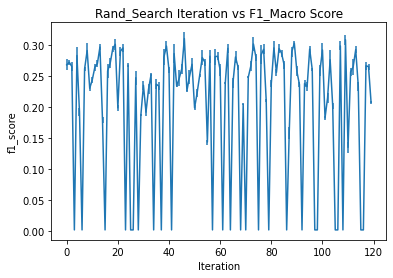

[(46, 0.3101651315337152), (109, 0.3081884587580743), (89, 0.3026079913423853), (73, 0.3013853828765749), (19, 0.30084923959028237)]
Best Parameters:  {'xgb_model__subsample': 0.8, 'xgb_model__reg_lambda': 0.8, 'xgb_model__n_estimators': 580, 'xgb_model__min_child_weight': 3, 'xgb_model__max_depth': 4, 'xgb_model__learning_rate': 0.1, 'xgb_model__gamma': 4, 'xgb_model__colsample_bytree': 0.8}
Best Score:  0.3101651315337152


In [235]:
rand_search = rand_search_eval(pipe_tuning, hype_params, sample_weights)

#### Final Hyper Parameters

In [236]:
# Final hyper_parameters
rand_search.best_params_

{'xgb_model__subsample': 0.8,
 'xgb_model__reg_lambda': 0.8,
 'xgb_model__n_estimators': 580,
 'xgb_model__min_child_weight': 3,
 'xgb_model__max_depth': 4,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__gamma': 4,
 'xgb_model__colsample_bytree': 0.8}

## Feature Importance

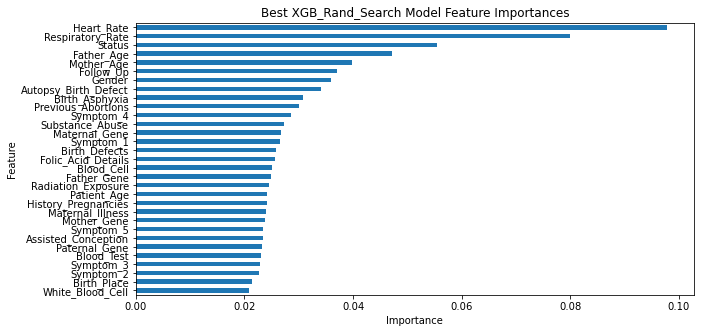

In [237]:
plt.subplots(figsize=(10, 5))
imps_features = rand_search.best_estimator_.named_steps.xgb_model.feature_importances_
rand_search_imps = pd.Series(imps_features, index=X_train.columns).sort_values(ascending=True)
rand_search_imps.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Best XGB_Rand_Search Model Feature Importances');
plt.show()

## Final Model

In [238]:
final_model = rand_search

pred_tr = final_model.predict(X_train)
pred_te = final_model.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

47.57720311323123
33.165955310067794


In [239]:
# Cross Validation Score
scores = cross_val_score(final_model.best_estimator_, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [42.29683088 40.72795733 42.05900816 38.66917765 40.26993095]
Mean: 40.8045809925799
Standard Deviation: 0.013154517486735436


In [240]:
# Cross Validation Score for F1_Macro Score Metric baseline
scores = cross_val_score(final_model.best_estimator_, X_train, y_train, cv=5, scoring="f1_macro")
print("F1_Macro Scores:", scores * 100)
print("F1_Macro Scores Mean:", scores.mean() * 100)
print("F1_Macro Scores Standard Deviation:", scores.std())

F1_Macro Scores: [30.22580045 30.53026823 30.42090022 26.65529811 29.7910243 ]
F1_Macro Scores Mean: 29.524658259544072
F1_Macro Scores Standard Deviation: 0.014567278373340806


In [241]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.22      0.17      0.19        29
           1       0.30      0.43      0.36        23
           2       0.37      0.43      0.39       647
           3       0.26      0.35      0.30       346
           4       0.27      0.59      0.38       266
           5       0.22      0.38      0.28       126
           6       0.45      0.24      0.31      1072
           7       0.36      0.28      0.31       901
           8       0.30      0.34      0.32       573

    accuracy                           0.33      3983
   macro avg       0.31      0.36      0.32      3983
weighted avg       0.36      0.33      0.33      3983



### Fitting and Saving Final Model to Entire Dataset

In [251]:
# Fit Final Model to Entire Training Data
final_model.best_estimator_.fit(X, encoded_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  SimpleImputer(fill_value=-99,
                                                                strategy='constant'),
                                                  Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('im...
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=580,
                               n_jobs=6, num_para

In [252]:
# Cross Validation Score
scores = cross_val_score(final_model.best_estimator_, X, encoded_y, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [41.32563394 39.74391162 41.85287472 40.87371328 41.30052724]
Mean: 41.019332161687174
Standard Deviation: 0.00709307697991805


In [253]:
# Cross Validation Score for F1_Macro Score Metric baseline
scores = cross_val_score(final_model.best_estimator_, X, encoded_y, cv=5, scoring="f1_macro")
print("F1_Macro Scores:", scores * 100)
print("F1_Macro Scores Mean:", scores.mean() * 100)
print("F1_Macro Scores Standard Deviation:", scores.std())

F1_Macro Scores: [29.75909987 29.62971288 28.89803852 28.31659485 28.86654874]
F1_Macro Scores Mean: 29.09399897113515
F1_Macro Scores Standard Deviation: 0.005336365552779871


In [257]:
# Saving the best model
best_model = final_model.best_estimator_

# Save the model as a pickle in a file
joblib.dump(best_model, '../Model/best_model.pkl')

['../Model/best_model.pkl']